<a href="https://colab.research.google.com/github/fanxu30/XAI/blob/main/assn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explainable Techniques II
Fan Xu

In [ ]:
!pip install alibi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load dataset
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame
X, y = df.drop('MEDV', axis=1), df['MEDV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print(f"R² Score: {r2_score(y_test, rf.predict(X_test)):.3f}")

R² Score: 0.892


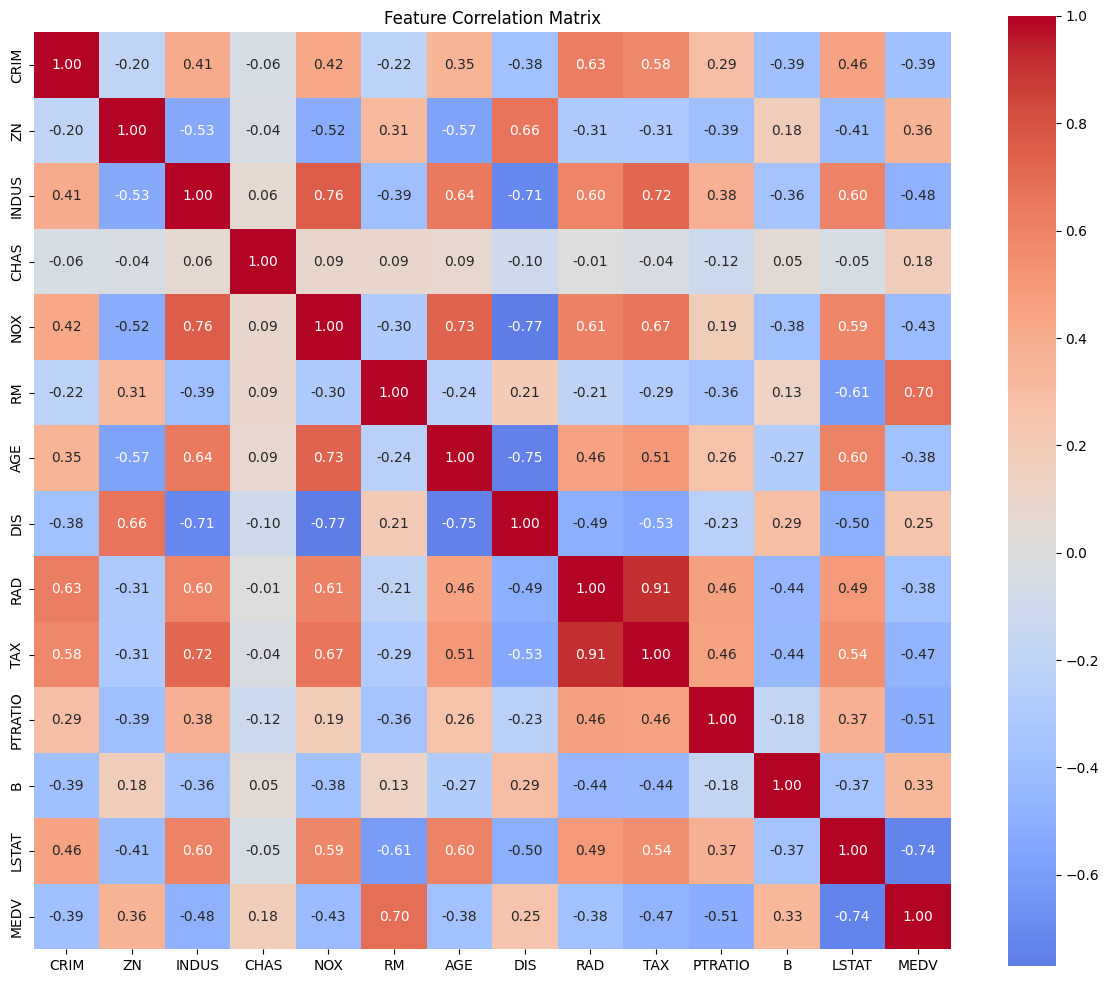

High correlations (|r| > 0.7):
INDUS - NOX: 0.764
INDUS - DIS: -0.708
INDUS - TAX: 0.721
NOX - AGE: 0.731
NOX - DIS: -0.769
AGE - DIS: -0.748
RAD - TAX: 0.910
LSTAT - MEDV: -0.738


In [2]:
# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify high correlations
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("High correlations (|r| > 0.7):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} - {feat2}: {corr:.3f}")

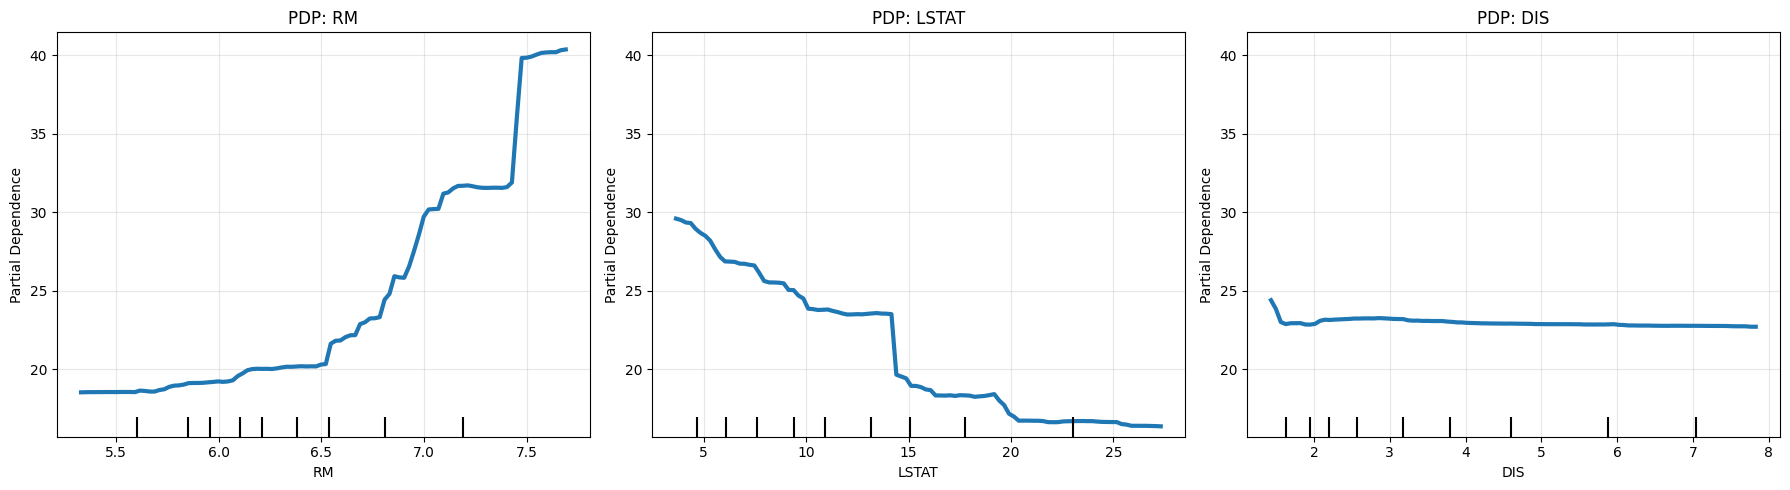

In [3]:
# PDP plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

features = ['RM', 'LSTAT', 'DIS']
PartialDependenceDisplay.from_estimator(
    rf, X_train, features,
    ax=ax, line_kw={'linewidth': 3}
)

for i, feature in enumerate(features):
    ax[i].set_title(f'PDP: {feature}')
    ax[i].set_ylabel('Partial Dependence')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

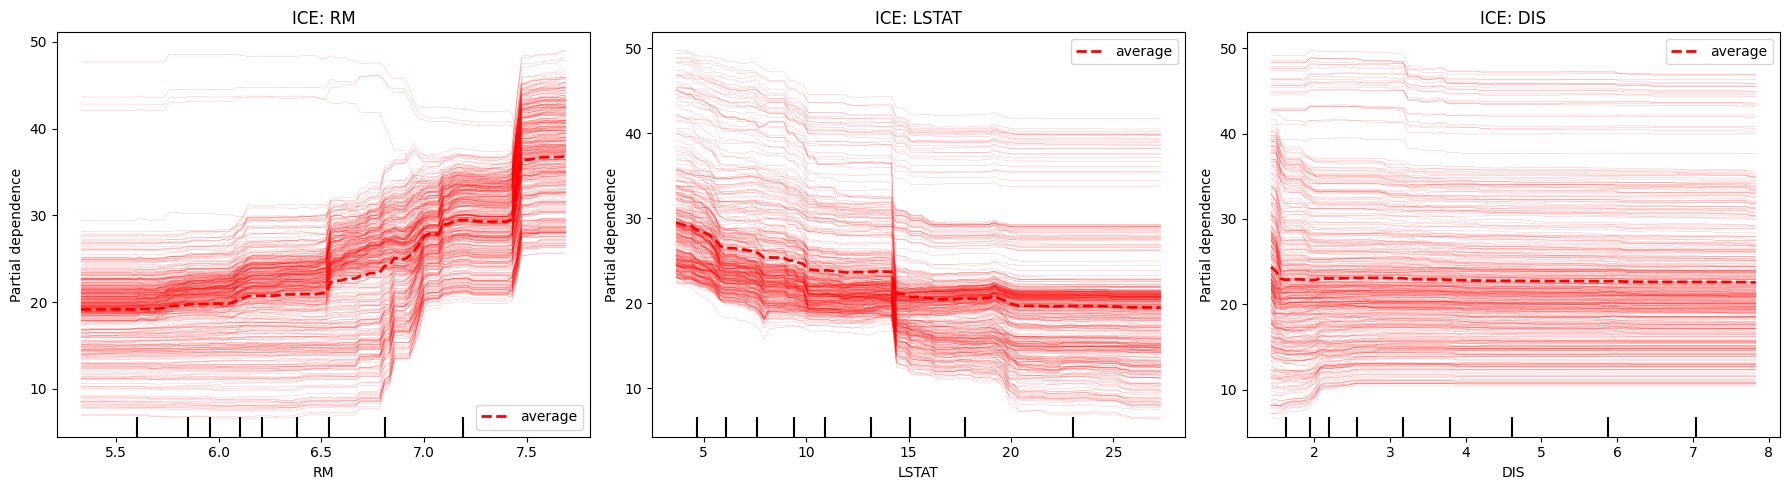

In [4]:
# ICE plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        rf, X_train, [feature],
        ax=ax[i], kind='both',
        line_kw={'linewidth': 2, 'color': 'red'},
        ice_lines_kw={'linewidth': 0.3, 'alpha': 0.3}
    )
    ax[i].set_title(f'ICE: {feature}')
    ax[i].set_ylabel('Predicted MEDV')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

TypeError: unsupported operand type(s) for -: 'str' and 'str'

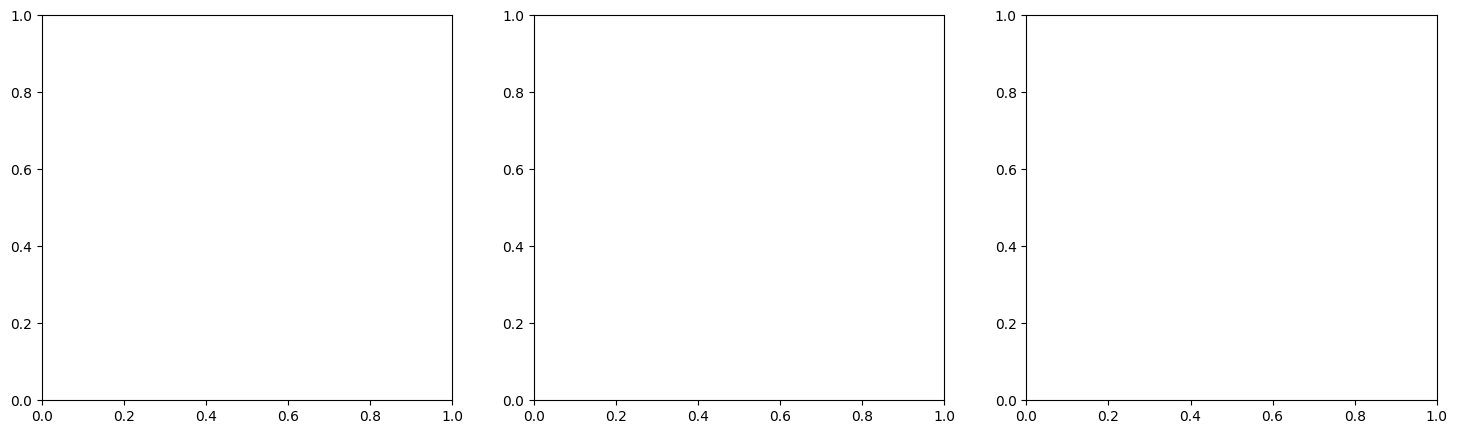

In [5]:
# ALE plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    ale = ALE(rf.predict, feature_names=X.columns)
    exp = ale.explain(X_train.values)

    ax[i].plot(exp.feature_values[i], exp.ale_values[i],
               linewidth=3, color='green')
    ax[i].fill_between(exp.feature_values[i],
                      exp.ale_values[i] - exp.ale_values[i].std(),
                      exp.ale_values[i] + exp.ale_values[i].std(),
                      alpha=0.3, color='green')
    ax[i].set_title(f'ALE: {feature}')
    ax[i].set_ylabel('ALE')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()